# A look at high energy data 

In [1]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import gc

module_dir = os.path.abspath('../src/')
sys.path.append(module_dir)

from parser_fun import merge_hdfs_multi, merge_hdfs_multi_reco, merge_hdfs_multi_reco_event
from plot_functions import auto_plot_style
from plot_functions import color_sequence
import plot_functions as pf

import analysis_functions as af
import HE_analysis_functions as afHE
import stats
import utility as ut

#Can be removed later
import importlib
importlib.reload(af)
importlib.reload(afHE)
from sklearn.cluster import DBSCAN
#

In [2]:
run_number = 15589
#folderdata = [f"/scratch/torellis/NEXTResoAnalysis/data/{run_number}/trg2"]
folderdata = ['/Users/samuele/Documents/Postdoc/NEXT/TrgEff/data/15607_subsample/trg2/ldc1/']

In [3]:
df = merge_hdfs_multi(folderdata)

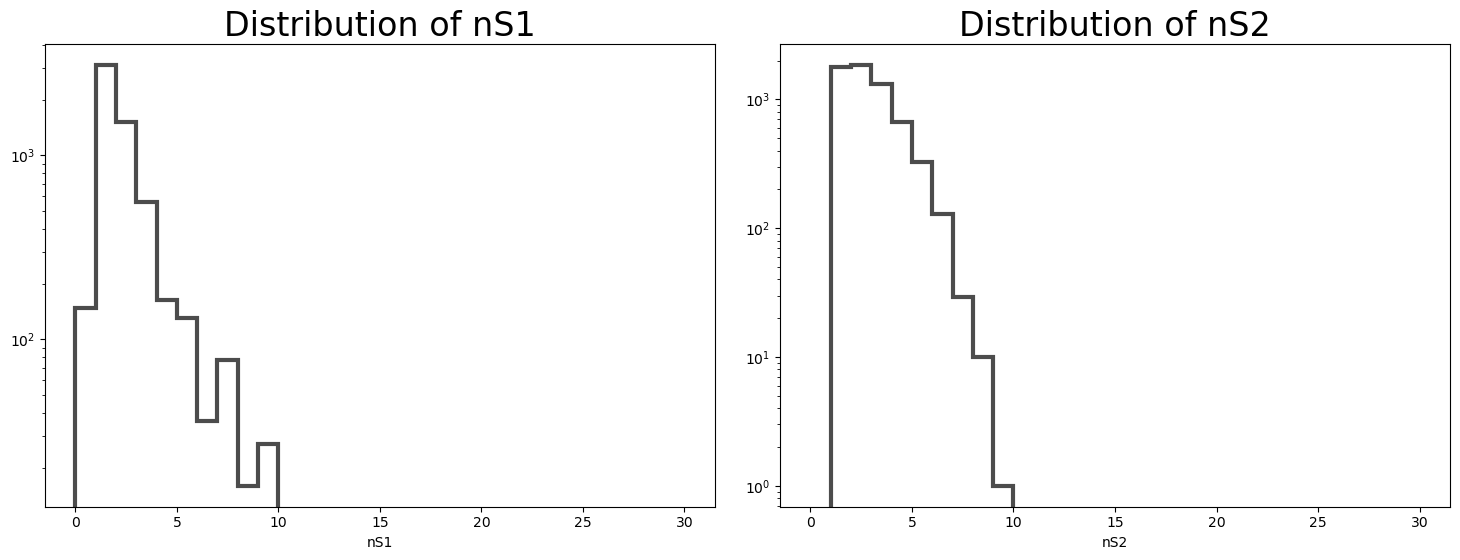

In [4]:
# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
auto_plot_style()

# Plot histogram of df_sel['s1w']
axes[0].hist(df[df['s2_peak']==0]['nS1'], bins=30, range=[0,30], histtype='step', color = color_sequence[0], alpha=0.7)
axes[0].set_xlabel('nS1')
axes[0].set_title('Distribution of nS1')
axes[0].set_yscale('log')

# Plot histogram of df_sel['s1e']
axes[1].hist(df[df['s2_peak']==0]['nS2'], bins=30, range = [0,30], histtype='step',color = color_sequence[0], alpha=0.7)
axes[1].set_xlabel('nS2')
axes[1].set_yscale('log')
axes[1].set_title('Distribution of nS2')

# Adjust layout for better spacing
plt.tight_layout()

In [5]:
df = df.dropna()
df.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

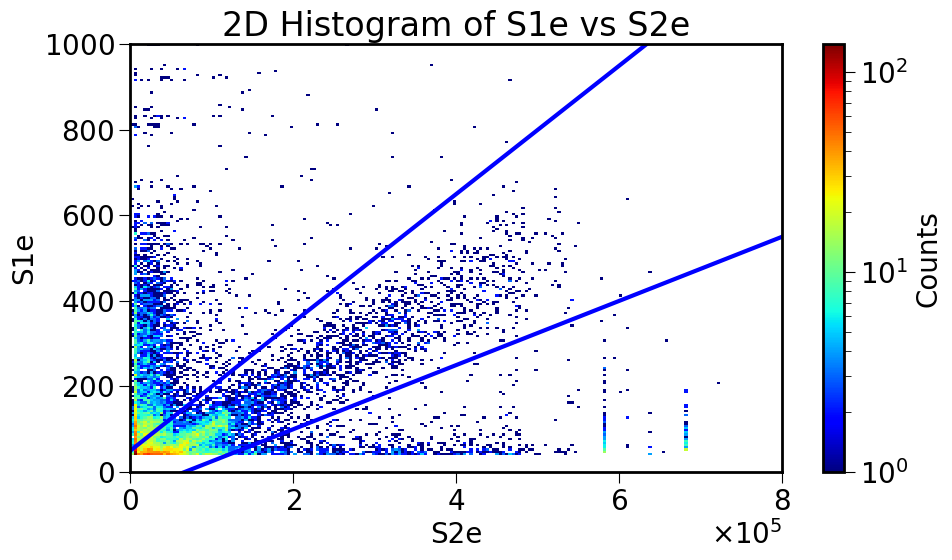

In [6]:
# Define histogram bins
x = df['S1e']
y = df['S2e']

xrange = (0,.8e6)
yrange = (0,1000)

# Compute 2D histogram
H, xedges, yedges = np.histogram2d(y, x, bins=(200,200), range= ( xrange, yrange) )

# Mask zero-count bins
H = np.where(H == 0, np.nan, H)

lineup = ut.line_from_points( 0.,50.,0.4e6,650 )
linedown = ut.line_from_points(0.2e6,100,0.6e6,400)

x_vals = np.linspace(0, 1e6, 1000)

# Evaluate the line at each x
y_vals = linedown(x_vals)

# Plot
plt.figure(figsize=(10, 6))
plt.pcolormesh(xedges, yedges, H.T, cmap='jet',norm = LogNorm())
plt.plot(x_vals, lineup(x_vals), label='linedown', color='blue')
plt.plot(x_vals, linedown(x_vals), label='linedown', color='blue')
plt.colorbar(label='Counts')
plt.xlabel('S2e')
plt.ylabel('S1e')
plt.xlim(xrange)
plt.ylim(yrange)
plt.title('2D Histogram of S1e vs S2e')
plt.tight_layout()
plt.show()

In [7]:
df_Sprop = df[(df['S1e'] >= linedown(df['S2e'])) & (df['S1e'] <= lineup(df['S2e']))]
print(f"NEvent filtered road : {len(np.unique(df_Sprop['event']))}")
print(f"eff:{(len(np.unique(df_Sprop['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 4044
eff:97.82%


In [8]:
df_Sprop_single_s1s2 = df_Sprop[(df_Sprop['nS1'] == 1) & (df_Sprop['nS2'] == 1)]

print(f"NEvent filtered road : {len(np.unique(df_Sprop_single_s1s2['event']))}")
print(f"eff:{(len(np.unique(df_Sprop_single_s1s2['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 1167
eff:28.23%


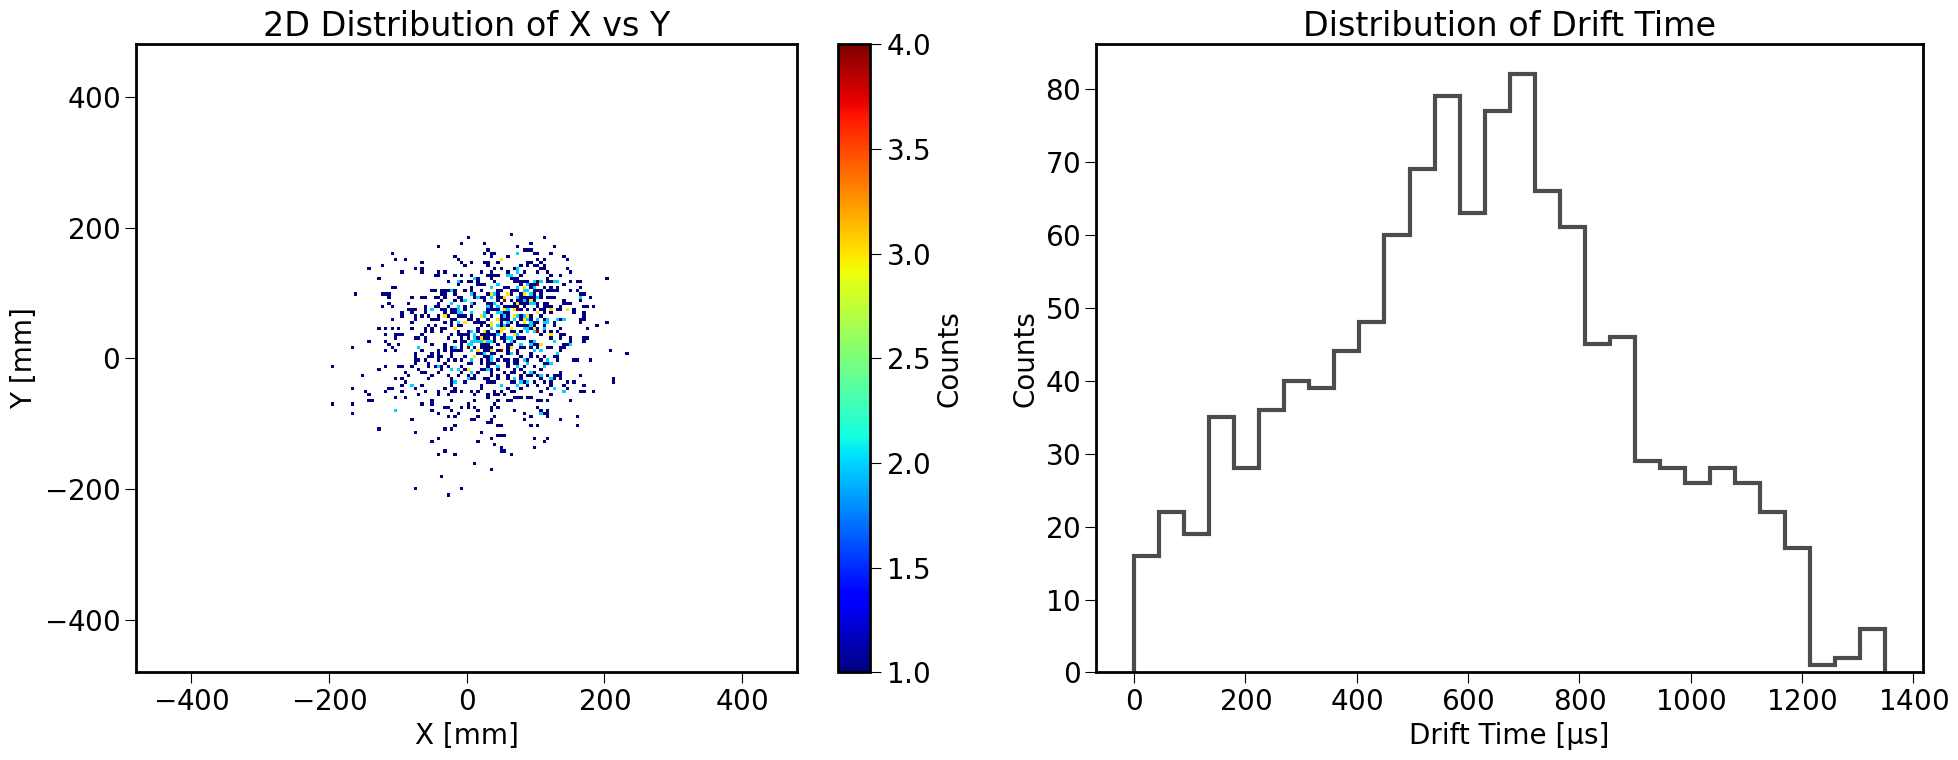

In [9]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
auto_plot_style()  # Assuming this sets fonts and colors

# --- 2D Histogram of X vs Y ---
H, xedges, yedges = np.histogram2d(
    df_Sprop_single_s1s2['X'], df_Sprop_single_s1s2['Y'],
    bins=(200, 200), range=((-480, 480), (-480, 480))
)
H = np.where(H == 0, np.nan, H)  # Mask zero counts

pcm = axes[0].pcolormesh(xedges, yedges, H.T, cmap='jet')
axes[0].set_xlabel('X [mm]')
axes[0].set_ylabel('Y [mm]')
axes[0].set_title('2D Distribution of X vs Y')

# Add colorbar
fig.colorbar(pcm, ax=axes[0], label='Counts')

# --- Histogram of Drift Time (DT) ---
axes[1].hist(
    df_Sprop_single_s1s2['DT'],
    bins=30, range=(0, 1350),
    histtype='step',
    color=color_sequence[0],
    alpha=0.7
)
axes[1].set_xlabel('Drift Time [μs]')
axes[1].set_ylabel('Counts')
axes[1].set_title('Distribution of Drift Time')

# Final layout
plt.tight_layout()
plt.show()

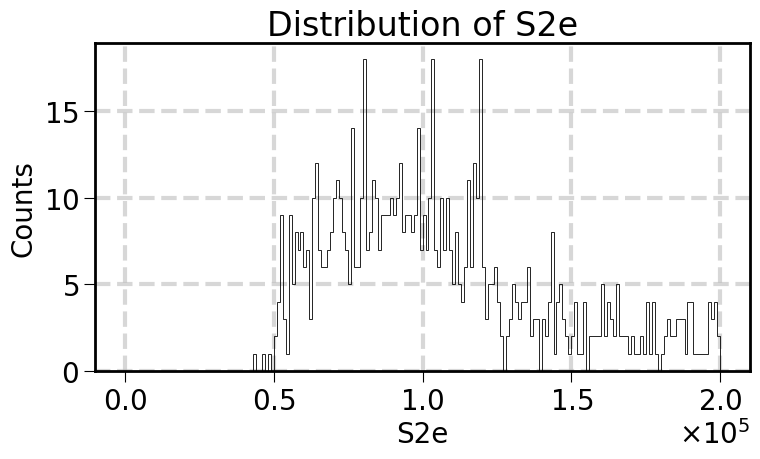

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(df_Sprop_single_s1s2['S2e'], bins=200, range=(0,2e5), histtype='step',linewidth = .6)
plt.xlabel('S2e')
plt.ylabel('Counts')
plt.title('Distribution of S2e')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
kr_map = af.load_kr_map('../db/kr_maps/map_run15586.npz')

In [12]:
df_Sprop_single_s1s2_coor = af.correct_S2e(df_Sprop_single_s1s2, kr_map, rmax=400.0, zmax=1350.0)

In [13]:
df_Sprop_single_s1s2_coor[['S2e','Epes','corrections']]

,S2e,Epes,corrections
4,525345.875000,518637.970140,1.012934
13,115981.640625,119222.975067,0.972813
40,57551.136719,59023.793486,0.975050
57,143610.734375,148857.928840,0.964750
58,268798.062500,273439.309550,0.983026
...,...,...,...
14748,396875.937500,400070.080918,0.992016
14753,95818.039062,96976.281739,0.988056
14757,336442.437500,350225.036770,0.960646
14758,79444.179688,82024.259125,0.968545


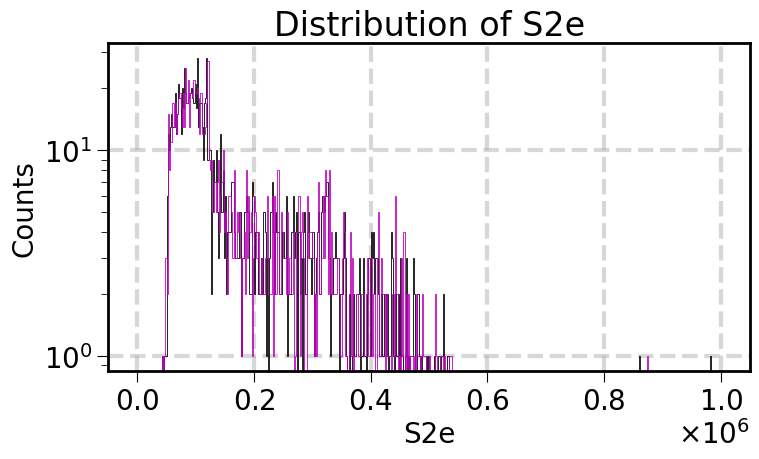

In [14]:
plt.figure(figsize=(8, 5))
plt.hist(df_Sprop_single_s1s2['S2e'], bins=500, range=(0,1e6), histtype='step',linewidth = .6)
plt.hist(df_Sprop_single_s1s2_coor['Epes'], bins=500, range=(0,1e6), histtype='step',linewidth = .6)
plt.xlabel('S2e')
plt.ylabel('Counts')
plt.title('Distribution of S2e')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
ev_list = df_Sprop_single_s1s2[(df_Sprop_single_s1s2['S2e']>0.4e6) & (df_Sprop_single_s1s2['S2e']<0.65e6)]['event'].unique()


In [16]:
ev_list


array([  19286,   90035,  186383,  295212,  340796,  460223,  514144,
        598074,  598144,  611367,  711292,  748455,  760467,  760558,
        782888,  968360,  971755,  972014, 1016366, 1055615, 1069384,
       1172123, 1196427, 1297892, 1372701, 1373317, 1441063, 1523663,
       1568617, 1603421, 1642698, 1680253, 1695646, 1696094, 1811132,
       1912611, 1983164, 2000622, 2111551, 2141700, 2182237, 2182258,
       2210769, 2235423, 2401617, 2401981, 2488396, 2617595, 2617770,
       2640856, 2641115, 2731814, 2795199, 2862245, 2867313, 2917314,
       2953014, 2953196, 3137835, 3173472, 3211272, 3211356, 3219917,
       3277814, 3277898, 3313542, 3449405, 3449699, 3452135, 3462740,
       3471861, 3546152, 3583840, 3593941, 3665607, 3675358, 3808204,
       3816576])

In [17]:
del df,df_Sprop,df_Sprop_single_s1s2, df_Sprop_single_s1s2_coor
gc.collect()

46076

In [18]:
folderdata_hits = [f"/Users/samuele/Documents/Postdoc/NEXT/TrgEff/data/15607_subsample/trg2/ldc1/"]

df_pe_peak = merge_hdfs_multi_reco_event(folderdata_hits,ev_list)

/Users/samuele/Documents/Postdoc/NEXT/TrgEff/data/15607_subsample/trg2/ldc1/
opening /Users/samuele/Documents/Postdoc/NEXT/TrgEff/data/15607_subsample/trg2/ldc1/ldc1.h5


In [19]:
df_pe_peak 

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,19286,1.752994e+09,25,53.790024,106.585988,1,-265.925,60.825,0.0,0.0,265.573750,5.311115,0.255788,-1.0,0.000001,-1,-1.0
1,19286,1.752994e+09,25,53.790024,106.585988,1,134.375,-464.375,0.0,0.0,265.573750,5.854967,0.281980,-1.0,NaN,-1,-1.0
2,19286,1.752994e+09,25,53.790024,106.585988,1,319.975,60.825,0.0,0.0,265.573750,5.252813,0.252980,-1.0,0.000001,-1,-1.0
3,19286,1.752994e+09,25,53.790024,106.585988,1,-65.775,383.875,0.0,0.0,268.026375,5.861424,0.454259,-1.0,0.000003,-1,-1.0
4,19286,1.752994e+09,25,53.790024,106.585988,1,351.075,307.625,0.0,0.0,268.026375,8.765768,0.679344,-1.0,0.000005,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236796,3816576,1.753079e+09,17,77.332700,88.351839,1,-158.075,214.825,0.0,0.0,873.786250,6.300169,5.732221,-1.0,0.000030,-1,-1.0
236797,3816576,1.753079e+09,17,77.332700,88.351839,1,10.975,-139.825,0.0,0.0,873.786250,5.487650,4.992949,-1.0,0.000026,-1,-1.0
236798,3816576,1.753079e+09,17,77.332700,88.351839,1,-373.775,122.025,0.0,0.0,876.697000,7.537134,0.692515,-1.0,0.000004,-1,-1.0
236799,3816576,1.753079e+09,17,77.332700,88.351839,1,-204.725,-139.825,0.0,0.0,876.697000,5.366126,0.493042,-1.0,0.000003,-1,-1.0


In [20]:
df_pe_peak = df_pe_peak[(df_pe_peak['Z']>0) & (df_pe_peak['Z']<1500)]


In [21]:
df_pe_peak = df_pe_peak.drop(columns=['Xpeak', 'Ypeak'])

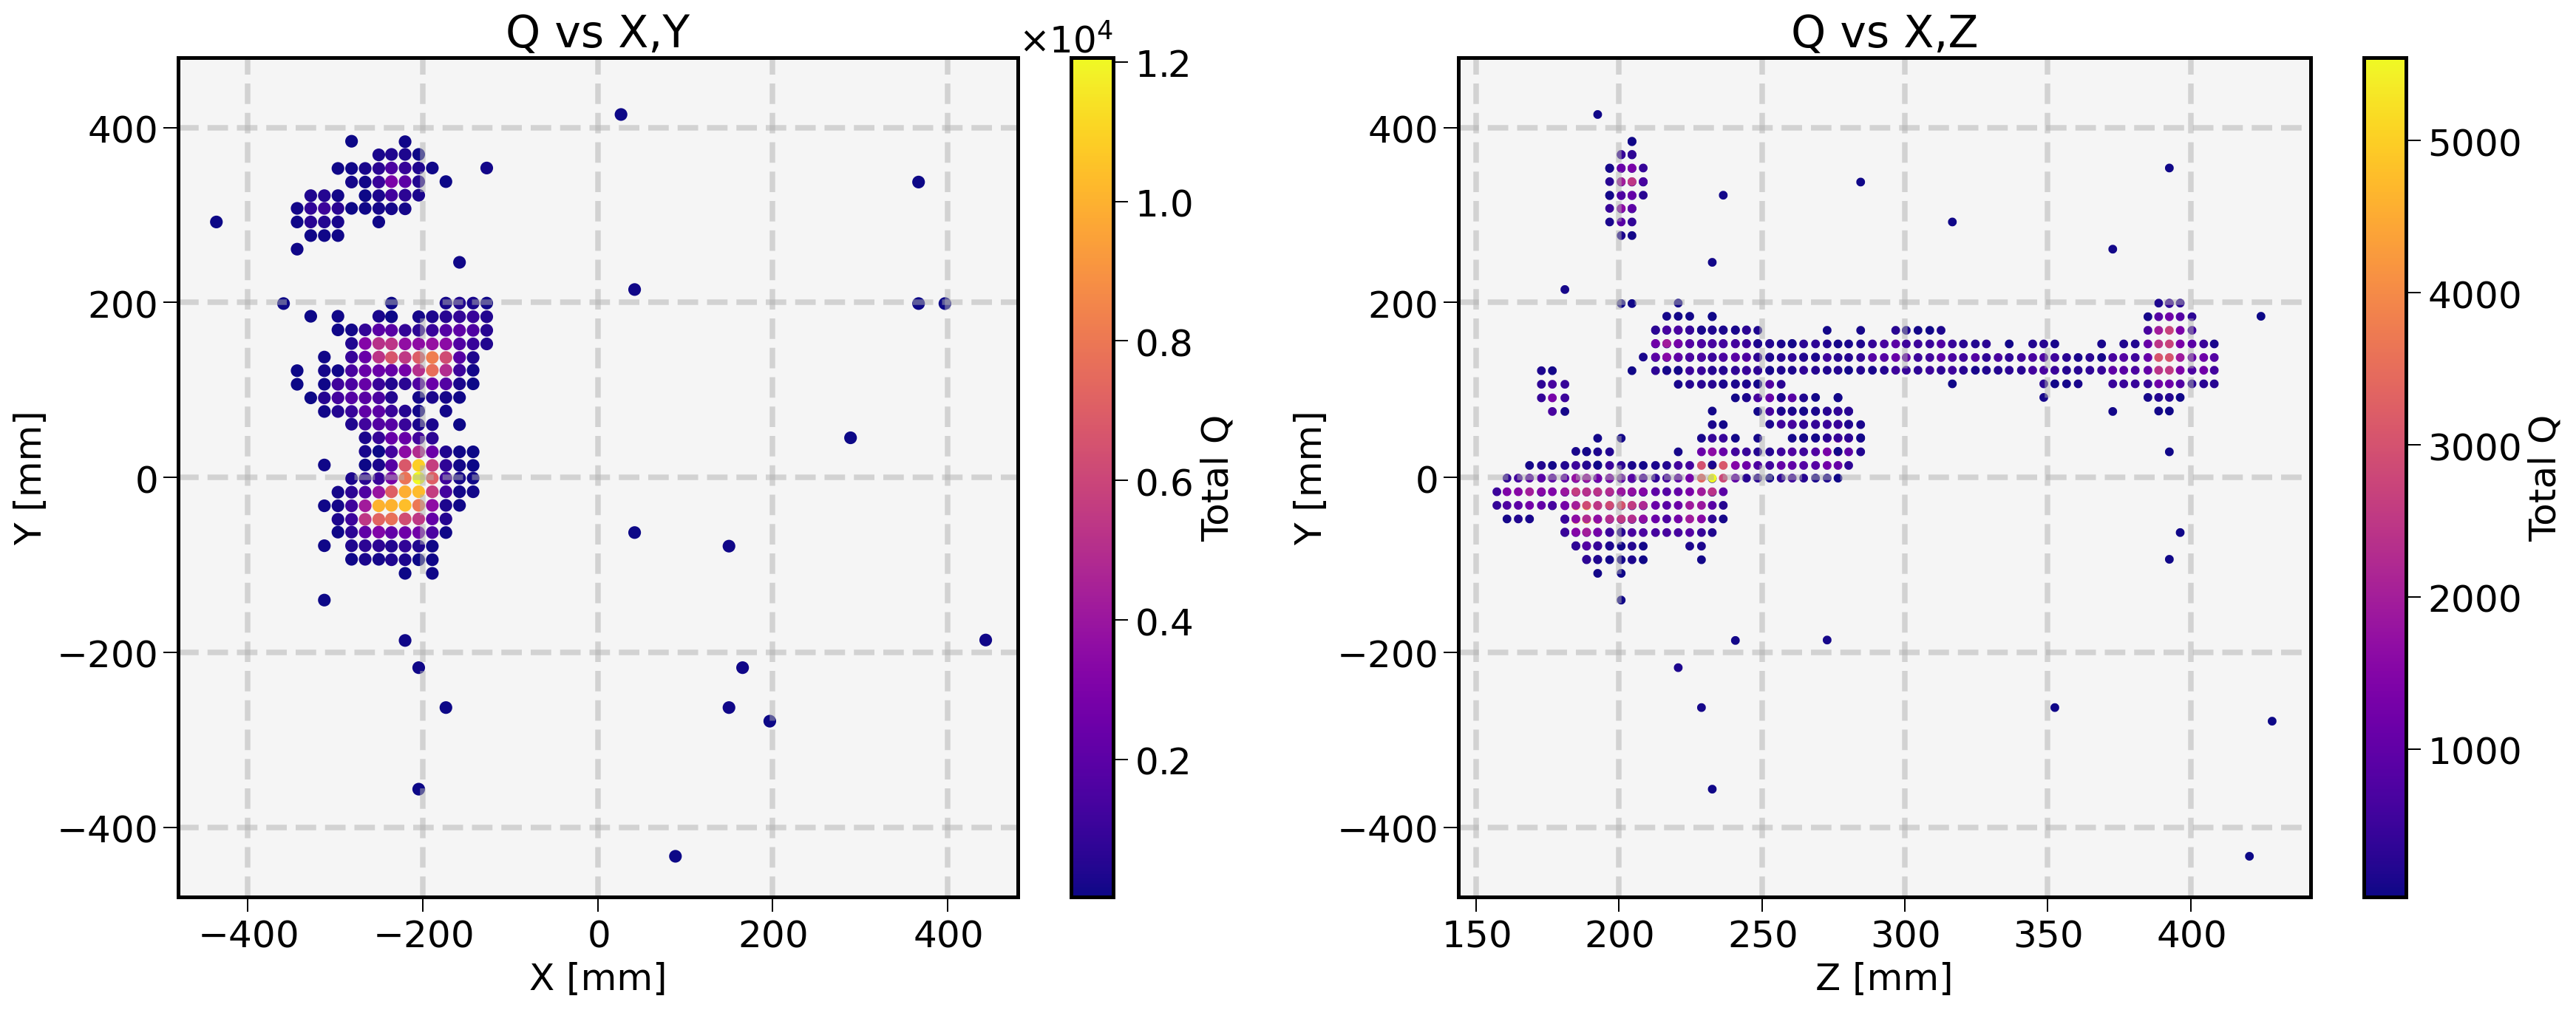

In [69]:
ev_list = df_pe_peak['event'].unique()
df_reco_event = df_pe_peak[(df_pe_peak['event'] == ev_list[13]) & (df_pe_peak['Q'] > 8)]

# Binning setup
xbins = ybins = 250
zbins = 100
xrange = (-480, 480)
yrange = (-480, 480)
zrange = (0, 1350)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi=180)

# Q vs (X,Y)
df_grouped = df_reco_event.groupby(['X', 'Y'], as_index=False)['E'].sum()
sc0 = axes[0].scatter(df_grouped['X'], df_grouped['Y'], c=df_grouped['E'], cmap='plasma', s=15, marker='o')
axes[0].set_title("Q vs X,Y")
axes[0].set_xlabel("X [mm]")
axes[0].set_ylabel("Y [mm]")
axes[0].set_xlim(-480,480)
axes[0].set_ylim(-480,480)
axes[0].set_aspect('equal')
axes[0].grid()
axes[0].set_facecolor("whitesmoke")
fig.colorbar(sc0, ax=axes[0], label="Total Q")

# Q vs (X,Z)
df_grouped = df_reco_event.groupby(['Z', 'Y'], as_index=False)['E'].sum()
sc1 = axes[1].scatter(df_grouped['Z'], df_grouped['Y'], c=df_grouped['E'], cmap='plasma', s=3, marker='o')
axes[1].set_title("Q vs X,Z")
axes[1].set_xlabel("Z [mm]")
axes[1].set_ylabel("Y [mm]")
axes[1].set_ylim(-480,480)
#axes[1].set_xlim(0,1350)
axes[1].set_facecolor("whitesmoke")
axes[1].grid()
fig.colorbar(sc1, ax=axes[1], label="Total Q")

plt.tight_layout()
plt.show()

In [70]:
# Example scaling
a = 14.55  # XY scale
b = 3.7  # Z scale

# Prepare data
X = df_reco_event[['X', 'Y', 'Z']].values

# Apply anisotropic scaling
X_scaled = X.copy()
X_scaled[:, 0] /= a
X_scaled[:, 1] /= a
X_scaled[:, 2] /= b

# Run DBSCAN with the precomputed distance
db = DBSCAN(eps=2.3, min_samples=5)
labels = db.fit_predict(X_scaled)

# Add labels to your DataFrame
df_reco_event['cluster'] = labels

/var/folders/pd/hx80lcqj1szc4vdz3mbmmv680000gn/T/ipykernel_44575/2344412048.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reco_event['cluster'] = labels


In [71]:
df_reco_event

,event,time,npeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep,cluster
39866,760558,1.753010e+09,28,1,-204.725,-31.975,0.0,0.0,157.215625,13.500645,233.284938,-1.0,0.001170,-1,-1.0,0
39867,760558,1.753010e+09,28,1,-204.725,-16.425,0.0,0.0,157.215625,15.245615,263.437224,-1.0,0.001325,-1,-1.0,0
39868,760558,1.753010e+09,28,1,-189.175,-31.975,0.0,0.0,157.215625,9.400488,162.436112,-1.0,0.000810,-1,-1.0,0
39869,760558,1.753010e+09,28,1,-189.175,-16.425,0.0,0.0,157.215625,14.029039,242.415356,-1.0,0.001222,-1,-1.0,0
39877,760558,1.753010e+09,28,1,-220.275,-31.975,0.0,0.0,160.758625,16.297428,146.517397,-1.0,0.000738,-1,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42713,760558,1.753010e+09,28,1,-173.625,152.625,0.0,0.0,408.299125,14.340067,118.631449,-1.0,0.000612,-1,-1.0,0
42715,760558,1.753010e+09,28,1,-158.075,137.075,0.0,0.0,408.299125,13.837104,114.470574,-1.0,0.000594,-1,-1.0,0
42725,760558,1.753010e+09,28,1,88.725,-433.275,0.0,0.0,420.613250,8.297209,26.109199,-1.0,0.000159,-1,-1.0,-1
42730,760558,1.753010e+09,28,1,-328.125,184.225,0.0,0.0,424.655875,8.317760,32.601851,-1.0,0.000182,-1,-1.0,-1


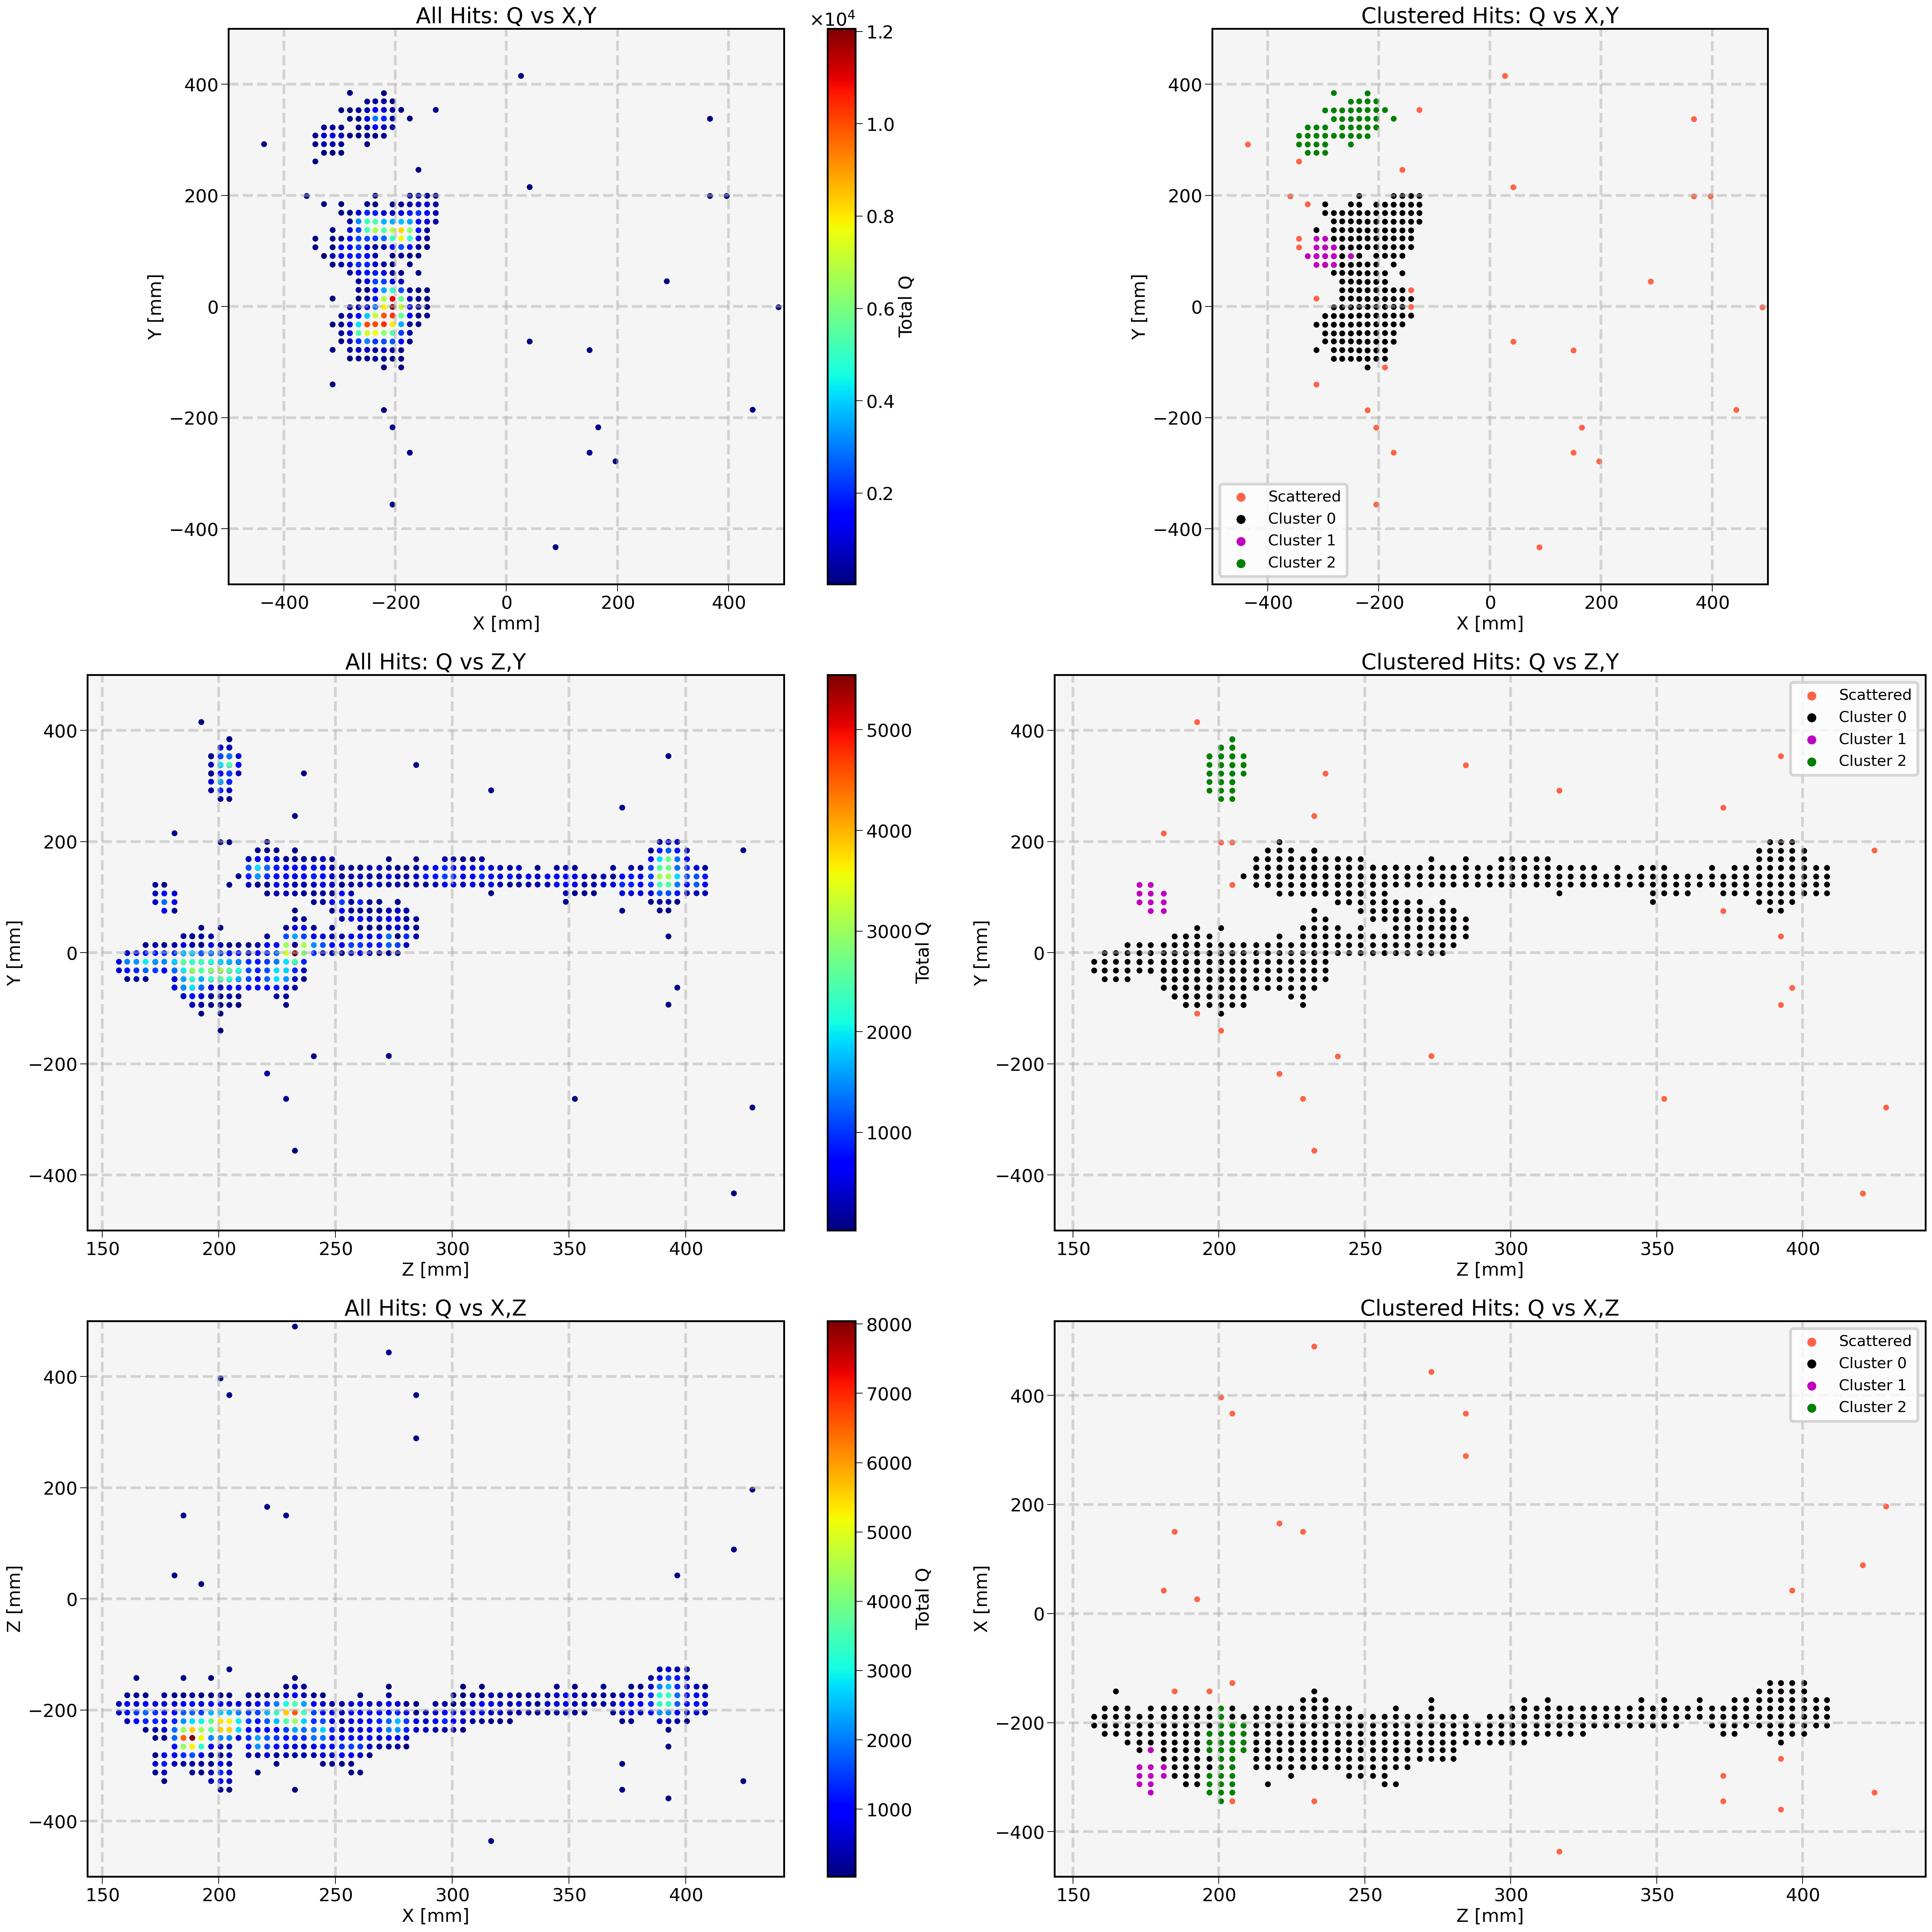

In [72]:
color_sequence = ("k", "m", "g", "b", "r",
                  "gray", "aqua", "gold", "lime", "purple",
                  "brown", "lawngreen", "tomato", "lightgray", "lightpink")

# Group total energy for coloring
df_grouped_xy = df_reco_event.groupby(['X', 'Y'], as_index=False)['E'].sum()
df_grouped_zy = df_reco_event.groupby(['Z', 'Y'], as_index=False)['E'].sum()
df_grouped_xz = df_reco_event.groupby(['X', 'Z'], as_index=False)['E'].sum()

# Group by cluster (includes Scattered)
df_clustered_xy = df_reco_event.groupby(['X', 'Y', 'cluster'], as_index=False)['E'].sum()
df_clustered_zy = df_reco_event.groupby(['Z', 'Y', 'cluster'], as_index=False)['E'].sum()
df_clustered_xz = df_reco_event.groupby(['X', 'Z', 'cluster'], as_index=False)['E'].sum()

# Create 3x2 plot
fig, axes = plt.subplots(3, 2, figsize=(30, 30), dpi=180)

# --- TOP LEFT: All hits X vs Y ---
sc0 = axes[0, 0].scatter(df_grouped_xy['X'], df_grouped_xy['Y'], c=df_grouped_xy['E'],
                         cmap='jet', s=12, marker='o')
axes[0, 0].set_title("All Hits: Q vs X,Y")
axes[0, 0].set_xlabel("X [mm]")
axes[0, 0].set_ylabel("Y [mm]")
axes[0, 0].set_xlim(-500, 500)
axes[0, 0].set_ylim(-500, 500)
axes[0, 0].set_aspect('equal')
axes[0, 0].grid()
axes[0, 0].set_facecolor("whitesmoke")
fig.colorbar(sc0, ax=axes[0, 0], label="Total Q")

# --- TOP RIGHT: Clustered hits X vs Y ---
for cl in sorted(df_clustered_xy['cluster'].unique()):
    cluster_df = df_clustered_xy[df_clustered_xy['cluster'] == cl]
    color = color_sequence[-3] if cl == -1 else color_sequence[cl]
    label = 'Scattered' if cl == -1 else f'Cluster {cl}'
    axes[0, 1].scatter(cluster_df['X'], cluster_df['Y'], s=12, marker='o', label=label, c=color)
axes[0, 1].set_title("Clustered Hits: Q vs X,Y")
axes[0, 1].set_xlabel("X [mm]")
axes[0, 1].set_ylabel("Y [mm]")
axes[0, 1].set_xlim(-500, 500)
axes[0, 1].set_ylim(-500, 500)
axes[0, 1].set_aspect('equal')
axes[0, 1].set_facecolor("whitesmoke")
axes[0, 1].grid()
axes[0, 1].legend(markerscale=2, fontsize='small')

# --- MIDDLE LEFT: All hits Z vs Y ---
sc2 = axes[1, 0].scatter(df_grouped_zy['Z'], df_grouped_zy['Y'], c=df_grouped_zy['E'],
                         cmap='jet', s=12, marker='o')
axes[1, 0].set_title("All Hits: Q vs Z,Y")
axes[1, 0].set_xlabel("Z [mm]")
axes[1, 0].set_ylabel("Y [mm]")
axes[1, 0].set_ylim(-500, 500)
axes[1, 0].set_facecolor("whitesmoke")
axes[1, 0].grid()
fig.colorbar(sc2, ax=axes[1, 0], label="Total Q")

# --- MIDDLE RIGHT: Clustered hits Z vs Y ---
for cl in sorted(df_clustered_zy['cluster'].unique()):
    cluster_df = df_clustered_zy[df_clustered_zy['cluster'] == cl]
    color = color_sequence[-3] if cl == -1 else color_sequence[cl]
    label = 'Scattered' if cl == -1 else f'Cluster {cl}'
    axes[1, 1].scatter(cluster_df['Z'], cluster_df['Y'], s=12, marker='o', label=label, c=color)
axes[1, 1].set_title("Clustered Hits: Q vs Z,Y")
axes[1, 1].set_xlabel("Z [mm]")
axes[1, 1].set_ylabel("Y [mm]")
axes[1, 1].set_ylim(-500, 500)
axes[1, 1].set_facecolor("whitesmoke")
axes[1, 1].grid()
axes[1, 1].legend(markerscale=2, fontsize='small')

# --- BOTTOM LEFT: All hits X vs Z ---
sc4 = axes[2, 0].scatter(df_grouped_xz['Z'], df_grouped_xz['X'], c=df_grouped_xz['E'],
                         cmap='jet', s=12, marker='o')
axes[2, 0].set_title("All Hits: Q vs X,Z")
axes[2, 0].set_xlabel("X [mm]")
axes[2, 0].set_ylabel("Z [mm]")
axes[2, 0].set_ylim(-500, 500)
axes[2, 0].set_facecolor("whitesmoke")
axes[2, 0].grid()
fig.colorbar(sc4, ax=axes[2, 0], label="Total Q")

# --- BOTTOM RIGHT: Clustered hits X vs Z ---
for cl in sorted(df_clustered_xz['cluster'].unique()):
    cluster_df = df_clustered_xz[df_clustered_xz['cluster'] == cl]
    color = color_sequence[-3] if cl == -1 else color_sequence[cl]
    label = 'Scattered' if cl == -1 else f'Cluster {cl}'
    axes[2, 1].scatter(cluster_df['Z'],cluster_df['X'], s=12, marker='o', label=label, c=color)
axes[2, 1].set_title("Clustered Hits: Q vs X,Z")
axes[2, 1].set_xlabel("Z [mm]")
axes[2, 1].set_ylabel("X [mm]")
#axes[2, 1].set_xlim(-500, 500)
axes[1, 1].set_ylim(-500, 500)
axes[2, 1].set_facecolor("whitesmoke")
axes[2, 1].grid()
axes[2, 1].legend(markerscale=2, fontsize='small')

plt.tight_layout()
plt.show()

In [51]:
diffs = np.sort(np.diff(df_reco_event['Z']))
diffs[diffs>0]

array([ 3.49375 ,  3.52925 ,  3.687625,  3.695625,  3.746125,  3.74825 ,
        3.775375,  3.7855  ,  3.78775 ,  3.810625,  3.816125,  3.816875,
        3.817625,  3.825   ,  3.825125,  3.831   ,  3.836125,  3.840875,
        3.841375,  3.8435  ,  3.849125,  3.850875,  3.8535  ,  3.854625,
        3.857   ,  3.859375,  3.859625,  3.861375,  3.862125,  3.863125,
        3.8665  ,  3.869   ,  3.87175 ,  3.87375 ,  3.879375,  3.88    ,
        3.8945  ,  3.89725 ,  3.907875,  3.908375,  3.9085  ,  3.911125,
        3.911375,  3.9125  ,  3.914125,  3.9205  ,  3.92125 ,  3.92625 ,
        3.931125,  3.9365  ,  3.93975 ,  3.940625,  3.942375,  3.947875,
        3.94825 ,  3.951125,  3.954625,  3.954875,  3.96325 ,  3.972375,
        3.97725 ,  3.979125,  3.97925 ,  3.9795  ,  3.989875,  3.998125,
        4.005   ,  4.00625 ,  4.00875 ,  4.011625,  4.014   ,  4.017625,
        4.018875,  4.021875,  4.024625,  4.024875,  4.02675 ,  4.02925 ,
        4.0325  ,  4.03975 ,  4.04975 ,  4.052   , 

In [52]:
diffs = np.sort(np.diff(df_reco_event['Y']))
diffs[diffs>0]

array([ 14.55,  14.55,  14.55, ..., 617.  , 632.55, 709.3 ])

In [53]:
a = 14.55  # XY scale
b = 3.7  # Z scale

# Pre-allocate array for cluster labels
cluster_labels = np.full(len(df_pe_peak), -9999, dtype=int)

# Get values once (faster than repeatedly accessing DataFrame columns)
coords = df_pe_peak[['X', 'Y', 'Z']].to_numpy()
events = df_pe_peak['event'].to_numpy()

# Use np.unique to get sorted event IDs
unique_events = np.unique(events)

for event_id in unique_events:
    mask = (events == event_id)
    X = coords[mask].copy()

    # Scale
    X[:, :2] /= a
    X[:, 2] /= b

    labels = DBSCAN(eps=2.3, min_samples=5).fit_predict(X)
    cluster_labels[mask] = labels

df_pe_peak['cluster'] = cluster_labels

In [54]:
df_pe_peak

,event,time,npeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep,cluster
0,19286,1.752994e+09,25,1,-265.925,60.825,0.0,0.0,265.573750,5.311115,0.255788,-1.0,0.000001,-1,-1.0,-1
1,19286,1.752994e+09,25,1,134.375,-464.375,0.0,0.0,265.573750,5.854967,0.281980,-1.0,NaN,-1,-1.0,-1
2,19286,1.752994e+09,25,1,319.975,60.825,0.0,0.0,265.573750,5.252813,0.252980,-1.0,0.000001,-1,-1.0,-1
3,19286,1.752994e+09,25,1,-65.775,383.875,0.0,0.0,268.026375,5.861424,0.454259,-1.0,0.000003,-1,-1.0,-1
4,19286,1.752994e+09,25,1,351.075,307.625,0.0,0.0,268.026375,8.765768,0.679344,-1.0,0.000005,-1,-1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236796,3816576,1.753079e+09,17,1,-158.075,214.825,0.0,0.0,873.786250,6.300169,5.732221,-1.0,0.000030,-1,-1.0,-1
236797,3816576,1.753079e+09,17,1,10.975,-139.825,0.0,0.0,873.786250,5.487650,4.992949,-1.0,0.000026,-1,-1.0,-1
236798,3816576,1.753079e+09,17,1,-373.775,122.025,0.0,0.0,876.697000,7.537134,0.692515,-1.0,0.000004,-1,-1.0,-1
236799,3816576,1.753079e+09,17,1,-204.725,-139.825,0.0,0.0,876.697000,5.366126,0.493042,-1.0,0.000003,-1,-1.0,-1


In [55]:
# Filter only valid clusters (exclude Scattered or unassigned, e.g. cluster == -1)
df_valid = df_pe_peak[df_pe_peak['cluster'] >= 0]

# Group by event and cluster, summing energy
cluster_energy = df_valid.groupby(['event', 'cluster'], sort=False)['Ec'].sum()

# Reshape into a DataFrame: rows=events, cols=clusters, values=E sums
cluster_energy_df = cluster_energy.unstack(fill_value=0)
cluster_energy

event    cluster
19286    0          2.508590
         1          0.002321
         2          0.001268
         3          0.001228
         4          0.003527
                      ...   
3665607  3          0.050479
3675358  0          2.304611
3808204  0          2.057956
         1          0.012086
3816576  0          2.022074
Name: Ec, Length: 184, dtype: float64

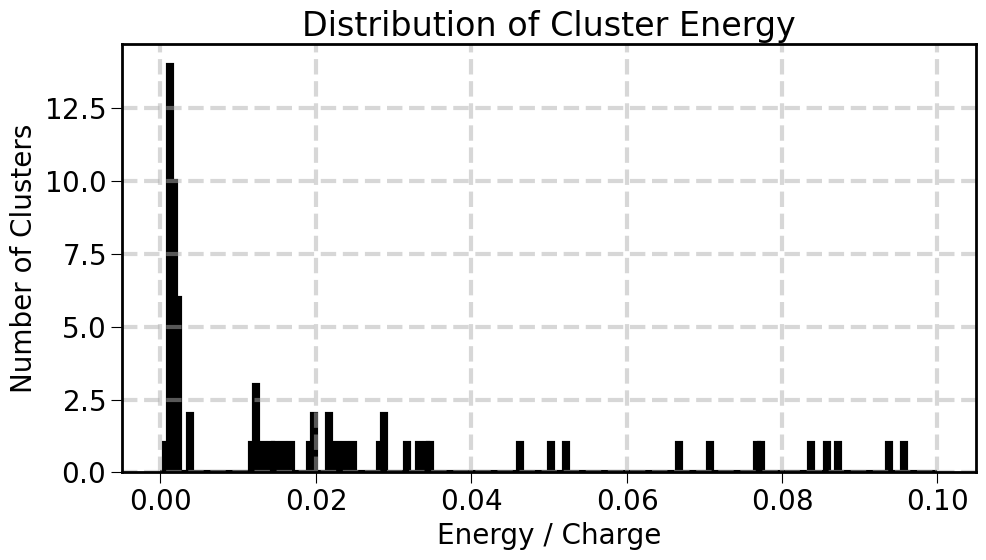

In [42]:
# If your DataFrame is called df_cluster_energy:
values = cluster_energy.values  # or df_cluster_energy.iloc[:, 0].values

plt.figure(figsize=(10, 6))
plt.hist(values, bins=200 , range= (0,0.1), color='steelblue', edgecolor='black')
plt.xlabel('Energy / Charge')
plt.ylabel('Number of Clusters')
plt.title('Distribution of Cluster Energy')
plt.grid(True)
plt.tight_layout()
plt.show()

# Energy sum of only cluster with higher energy

In [ ]:
# Filter only valid clusters (exclude Scattered or unassigned, e.g. cluster == -1)
df_valid = df_pe_peak[df_pe_peak['cluster'] >= 0]

# Group by event and cluster, summing energy
cluster_energy = df_valid.groupby(['event', 'cluster'], sort=False)['Ec'].sum()

# Reshape into a DataFrame: rows=events, cols=clusters, values=E sums
cluster_energy_df = cluster_energy.unstack(fill_value=0)

# Find the highest energy per event
max_energy_per_event = cluster_energy_df.max(axis=1)

In [ ]:
# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(max_energy_per_event.values, bins=350,range = (2.0,3), color='dodgerblue', edgecolor='black')
plt.xlabel('Max Cluster Energy per Event')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster E (cluster ≥ 0)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

bins = 150
a_range = (2.0,3)

# Histogram as data (not just plot)
data = max_energy_per_event.values
counts, bin_edges = np.histogram(data, bins = bins,range = a_range)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# ---- FITTING RANGE ----
fit_min = 2.5
fit_max = 2.7

# Mask bins within fit range
fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
x_fit = bin_centers[fit_mask]
y_fit = counts[fit_mask]

# Initial guesses: amplitude, mean, std
A0 = y_fit.max()
mu0 = x_fit[np.argmax(y_fit)]
sigma0 = 0.1

# Fit
popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=[A0, mu0, sigma0])
A, mu, sigma = popt

# ---- PLOTTING ----
plt.figure(figsize=(10, 6))
plt.hist(data, bins = bins,range = a_range, color='dodgerblue', edgecolor='black', label='Data')
plt.plot(x_fit, gaussian(x_fit, *popt), color='red', lw=2, label=f'Gaussian Fit\nμ={mu:.2f}, σ={sigma:.4f}\n reso= {sigma/mu*100:.3f}%')
plt.xlabel('Max Cluster Energy per Event')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster E')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Energy sum of only cluster with higher energy and ""Scattered""

In [ ]:
results = []

# Group by event for efficient processing
for event_id, df_event in df_pe_peak.groupby('event', sort=False):
    # Filter valid clusters
    df_clusters = df_event[df_event['cluster'] >= 0]

    # Get cluster with max Ec
    cluster_sums = df_clusters.groupby('cluster')['Ec'].sum()
    max_cluster_id = cluster_sums.idxmax()
    max_cluster_energy = cluster_sums.max()

    # Z range of that cluster
    df_max_cluster = df_clusters[df_clusters['cluster'] == max_cluster_id]
    z_min = df_max_cluster['Z'].min()
    z_max = df_max_cluster['Z'].max()

    # Get noise (cluster == -1) in that Z range
    df_scattered = df_event[(df_event['cluster'] == -1) & 
                            (df_event['Z'] >= z_min) & (df_event['Z'] <= z_max)]

    scattered_energy = df_scattered['Ec'].sum()

    # Total = main cluster + scattered
    total_energy = max_cluster_energy + scattered_energy

    results.append({
        'event': event_id,
        'max_cluster_id': max_cluster_id,
        'cluster_energy': max_cluster_energy,
        'scattered_energy': scattered_energy,
        'total_energy': total_energy,
        'z_min': z_min,
        'z_max': z_max,
    })

# Create resulting DataFrame
df_total_energy = pd.DataFrame(results)

In [ ]:
plt.figure(figsize=(10, 6), dpi=150)
plt.hist(df_total_energy['total_energy'], bins=350, color='steelblue', edgecolor='black')
plt.xlabel('Max Cluster Energy + Scattered Energy')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster Energy (with Scattered Added)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

data = df_total_energy['total_energy']

bins=180
a_range = (2.,3)

# Histogram as data (not just plot)
counts, bin_edges = np.histogram(data, bins=bins, range= a_range)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# ---- FITTING RANGE ----
fit_min = 2.65
fit_max = 2.81

# Mask bins within fit range
fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
x_fit = bin_centers[fit_mask]
y_fit = counts[fit_mask]

# Initial guesses: amplitude, mean, std
A0 = y_fit.max()
mu0 = x_fit[np.argmax(y_fit)]
sigma0 = 0.3

# Fit
popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=[A0, mu0, sigma0])
A, mu, sigma = popt

# ---- PLOTTING ----
plt.figure(figsize=(10, 6))
plt.hist(data, bins=bins, range= a_range, color='dodgerblue', edgecolor='black', label='Data')
plt.plot(x_fit, gaussian(x_fit, *popt), color='red', lw=2, label=f'Gaussian Fit\nμ={mu:.3f}, σ={sigma:.3f}\n reso= {sigma/mu*100:.3f}%')
plt.xlabel('Max Cluster Energy per Event')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster E (cluster ≥ 0)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Filter the data
filtered = df_total_energy[(df_total_energy['total_energy'] > 2.6) & 
                           (df_total_energy['total_energy'] < 2.8)]

# Compute Z span and cluster energy
z_span = filtered['z_max'] - filtered['z_min']
cluster_energy = filtered['total_energy']

# Define bins
x_bins = 20  # Z span
y_bins = 20  # Cluster energy

# Create 2D histogram
counts, xedges, yedges = np.histogram2d(z_span, cluster_energy, bins=[x_bins, y_bins])

# Set zero-count bins to NaN
counts[counts == 0] = np.nan

# Plot
plt.figure(figsize=(10, 6), dpi=150)
mesh = plt.pcolormesh(xedges, yedges, counts.T, cmap='jet', shading='auto')

# Labels and colorbar
plt.xlabel('Z Span (Zmax - Zmin) [mm]')
plt.ylabel('Cluster Energy [Ec]')
plt.title('2D Histogram: Cluster Energy vs Z Span')
plt.colorbar(mesh, label='Counts')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
df_total_energy

# Characterization of scattered charge vs energy in the slice

In [ ]:
# Step 1: Filter valid clusters (exclude -1)
df_valid = df_pe_peak[df_pe_peak['cluster'] >= 0]

# Step 2: Sum E per (event, cluster)
cluster_energy = df_valid.groupby(['event', 'cluster'], sort=False)['E'].sum()

# Step 3: Get the cluster with max E for each event
best_clusters = cluster_energy.groupby('event').idxmax()  # returns (event, cluster) tuples
best_clusters_df = pd.DataFrame(best_clusters.tolist(), columns=['event', 'cluster'])

# Step 4: Merge to get full row indices
df_best = df_pe_peak.merge(best_clusters_df, on=['event', 'cluster'])

# Step 5: Get also Scattered (cluster == -1)
df_Scattered = df_pe_peak[df_pe_peak['cluster'] == -1]

# Step 6: Combine both
df_result = pd.concat([df_best, df_Scattered], ignore_index=True)

In [ ]:
df_result

In [ ]:
slice_results = []

for event_id, df_event in df_pe_peak.groupby('event'):
    df_c0 = df_event[df_event['cluster'] == 0]

    z_min = df_c0['Z'].min()
    z_max = df_c0['Z'].max()

    # Define Z slice edges
    bins = np.arange(z_min, z_max + 40, 40)

    df_event = df_event.copy()
    df_event['z_slice'] = np.digitize(df_event['Z'], bins) - 1

    for slice_idx in range(len(bins) - 1):
        df_slice = df_event[df_event['z_slice'] == slice_idx]

        total_Q = df_slice['Q'].sum()
        Scattered_points = df_slice[df_slice['cluster'] == -1]
        Scattered_count = len(Scattered_points)
        Scattered_Q = Scattered_points['Q'].sum()

        slice_results.append({
            'event': event_id,
            'slice_idx': slice_idx,
            'z_start': bins[slice_idx],
            'z_end': bins[slice_idx + 1],
            'total_Q': total_Q,
            'Scattered_count': Scattered_count,
            'Scattered_Q': Scattered_Q
        })

# Create DataFrame with results
df_slices = pd.DataFrame(slice_results)

In [ ]:
df_slices

In [ ]:
# Get data
x1 = df_slices['Scattered_count']
y1 = df_slices['total_Q']

x2 = df_slices['Scattered_Q']
y2 = df_slices['total_Q']

# --- Compute histogram 1 ---
counts1, xedges1, yedges1 = np.histogram2d(y1, x1, bins=[200, 200])
counts1[counts1 == 0] = np.nan  # set 0s to NaN

# --- Compute histogram 2 ---
counts2, xedges2, yedges2 = np.histogram2d(y2, x2, bins=[200, 200])
counts2[counts2 == 0] = np.nan  # set 0s to NaN

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi=180)

# Plot 1: Scattered count vs total_Q
mesh1 = axes[0].pcolormesh(xedges1, yedges1, counts1.T, cmap='jet', shading='auto', norm=LogNorm())
fig.colorbar(mesh1, ax=axes[0], label='Counts')
axes[0].set_title('SiPM Scattered counts vs SiPM Charge main track')
axes[0].set_xlabel('SiPM Charge slice (Pes)')
axes[0].set_ylabel('Scattered Counts')
axes[0].grid(False)

# Plot 2: Scattered Q vs total_Q
mesh2 = axes[1].pcolormesh(xedges2, yedges2, counts2.T, cmap='jet', shading='auto', norm=LogNorm())
fig.colorbar(mesh2, ax=axes[1], label='Counts')
axes[1].set_title('SiPM Charge Scattered vs SiPM Charge main track')
axes[1].set_xlabel('SiPM Charge slice (Pes)')
axes[1].set_ylabel('Scattered Charge (Pes)')
axes[1].grid(False)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6), dpi=150)
plt.hist(df_slices['Scattered_Q'], bins=350, color='steelblue', edgecolor='black')
plt.xlabel('Max Cluster Energy + Scattered Energy')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster Energy (with Scattered Added)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_pe_peak

In [ ]:
kr_map = af.load_kr_map('../db/kr_maps/average_map_15614_15615.npz')

In [ ]:
df_pe_peak = afHE.correct_Hits(df_pe_peak,kr_map)

In [ ]:
df_pe_peak

# Analysis not counting scattered energy

In [ ]:
# Filter only valid clusters (exclude Scattered or unassigned, e.g. cluster == -1)
df_valid = df_pe_peak[df_pe_peak['cluster'] >= 0]

# Group by event and cluster, summing energy
cluster_energy = df_valid.groupby(['event', 'cluster'], sort=False)['Ec'].sum()

# Reshape into a DataFrame: rows=events, cols=clusters, values=E sums
cluster_energy_df = cluster_energy.unstack(fill_value=0)

# Find the highest energy per event
max_energy_per_event = cluster_energy_df.max(axis=1)

In [ ]:
# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(max_energy_per_event.values, bins=350, color='dodgerblue', edgecolor='black')
plt.xlabel('Max Cluster Energy per Event')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster E (cluster ≥ 0)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- Define functions ---
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def exponential(x, B, lamb):
    return B * np.exp(-lamb * x)

def gauss_plus_exp(x, A, mu, sigma, B, lamb):
    return gaussian(x, A, mu, sigma) + exponential(x, B, lamb)

# --- Histogram parameters ---
bins = 150
a_range = (4.5e5, 5.5e5)

# --- Histogram data ---
data = max_energy_per_event.values
counts, bin_edges = np.histogram(data, bins=bins, range=a_range)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# --- Fit range mask ---
fit_min = 4.8e5
fit_max = 5.2e5
fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
x_fit = bin_centers[fit_mask]
y_fit = counts[fit_mask]

# --- Initial guesses ---
A0 = y_fit.max()
mu0 = x_fit[np.argmax(y_fit)]
sigma0 = 2000
B0 = y_fit.min()
lamb0 = 1e-6

# --- Fit ---
p0 = [A0, mu0, sigma0, B0, lamb0]
bounds = (0, [np.inf, np.inf, np.inf, np.inf, np.inf])  # optional: constrain to positive values

popt, pcov = curve_fit(gauss_plus_exp, x_fit, y_fit, p0=p0, bounds=bounds)
A, mu, sigma, B, lamb = popt

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.hist(data, bins=bins, range=a_range, color='dodgerblue', edgecolor='blue', label='Data')

x_plot = np.linspace(fit_min, fit_max, 1000)
plt.plot(x_plot, gauss_plus_exp(x_plot, *popt), 'r-', lw=2, label=f'Gaussian + Exp Fit\nμ={mu:.2f}, σ={sigma:.2f}, Reso={sigma/mu*100:.3f}%')
plt.plot(x_plot, gaussian(x_plot, A, mu, sigma), 'g--', lw=1.5, label='Gaussian component')
plt.plot(x_plot, exponential(x_plot, B, lamb), 'k--', lw=1.5, label='Exponential component')

plt.xlabel('Max Cluster Energy per Event')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster E')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
results = []

# Group by event for efficient processing
for event_id, df_event in df_pe_peak.groupby('event', sort=False):
    # Filter valid clusters
    df_clusters = df_event[df_event['cluster'] >= 0]

    # Get cluster with max Ec
    cluster_sums = df_clusters.groupby('cluster')['Ec'].sum()
    if cluster_sums.empty:
        continue
        
    max_cluster_id = cluster_sums.idxmax()
    max_cluster_energy = cluster_sums.max()

    # Z range of that cluster
    df_max_cluster = df_clusters[df_clusters['cluster'] == max_cluster_id]
    z_min = df_max_cluster['Z'].min()
    z_max = df_max_cluster['Z'].max()

    # Get noise (cluster == -1) in that Z range
    df_scattered = df_event[(df_event['cluster'] == -1) & 
                            (df_event['Z'] >= z_min) & (df_event['Z'] <= z_max)]

    scattered_energy = df_scattered['Ec'].sum()

    # Total = main cluster + scattered
    total_energy = max_cluster_energy + scattered_energy

    results.append({
        'event': event_id,
        'max_cluster_id': max_cluster_id,
        'cluster_energy': max_cluster_energy,
        'scattered_energy': scattered_energy,
        'total_energy': total_energy,
        'z_min': z_min,
        'z_max': z_max,
    })

# Create resulting DataFrame
df_total_energy = pd.DataFrame(results)

In [ ]:
plt.figure(figsize=(10, 6), dpi=150)
plt.hist(df_total_energy['total_energy'], bins=350, color='steelblue', edgecolor='black')
plt.xlabel('Max Cluster Energy + Scattered Energy')
plt.ylabel('Number of Events')
plt.title('Distribution of Max Cluster Energy (with Scattered Added)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- Define functions ---
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def exponential(x, B, lamb):
    return B * np.exp(-lamb * x)

def gauss_plus_exp(x, A, mu, sigma, B, lamb):
    return gaussian(x, A, mu, sigma) + exponential(x, B, lamb)

# --- Histogram parameters ---
bins = 200
a_range = (4e5, 6e5)

# --- Histogram data ---
data = df_total_energy['total_energy'].values
counts, bin_edges = np.histogram(data, bins=bins, range=a_range)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# --- Fit range mask ---
fit_min = 5e5
fit_max = 5.5e5
fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
x_fit = bin_centers[fit_mask]
y_fit = counts[fit_mask]

# --- Initial guesses ---
A0 = y_fit.max()
mu0 = x_fit[np.argmax(y_fit)]
sigma0 = 2000
B0 = y_fit.min()
lamb0 = 1e-6

# --- Fit ---
p0 = [A0, mu0, sigma0, B0, lamb0]
bounds = (0, [np.inf, np.inf, np.inf, np.inf, np.inf])  # optional: constrain to positive values

popt, pcov = curve_fit(gauss_plus_exp, x_fit, y_fit, p0=p0, bounds=bounds)
A, mu, sigma, B, lamb = popt

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.hist(data, bins=bins, range=a_range, color='dodgerblue', edgecolor='blue', label='Data')

x_plot = np.linspace(fit_min, fit_max, 1000)
plt.plot(x_plot, gauss_plus_exp(x_plot, *popt), 'r-', lw=2, label=f'Gaussian + Exp Fit\nμ={mu:.2f}, σ={sigma:.2f}, Reso={sigma/mu*100:.3f}%')
plt.plot(x_plot, gaussian(x_plot, A, mu, sigma), 'g--', lw=1.5, label='Gaussian component')
plt.plot(x_plot, exponential(x_plot, B, lamb), 'k--', lw=1.5, label='Exponential component')

plt.xlabel('E corrected (Pes)')
plt.ylabel('Counts')
plt.grid(True)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

# Analysis removing the hits before correcting

In [ ]:
def remove_scatter_and_reweight(df: pd.DataFrame) -> pd.DataFrame:

    # Compute Eslice for each (event, Z)                                                                                                                                                                                                                  
    eslice = df.groupby(['event', 'Z'])['E'].sum().rename("Eslice")
    df = df.merge(eslice, on=['event', 'Z'])

    # Mask for signal rows (cluster >= 0)                                                                                                                                                                                                                 
    signal_mask = df['cluster'] >= 0

    # Compute Qsum for signal rows grouped by (event, Z)                                                                                                                                                                                                  
    qsum = df[signal_mask].groupby(['event', 'Z'])['Q'].sum().rename("Qsum")

    # Merge Qsum back to original DataFrame; use left join to preserve all rows                                                                                                                                                                           
    df = df.merge(qsum, on=['event', 'Z'], how='left')

    # Compute Erw only for signal rows                                                                                                                                                                                                                    
    df['Erw'] = np.where(
        signal_mask,
        df['Eslice'] * df['Q'] / df['Qsum'],
        np.nan
    )
    #df = df.drop(columns=['Xpeak', 'Ypeak','nsipm', 'Qc'])
    df = df[df['cluster']!=-1]

    return df


In [ ]:
df_pe_peak = remove_scatter_and_reweight(df_pe_peak)

In [ ]:
df_pe_peak = df_pe_peak.drop(columns=['Eslice', 'Qsum']) 

In [ ]:
df_pe_peak = afHE.correct_Hits(df_pe_peak,kr_map,var='Erw')

In [ ]:
df_pe_peak

In [ ]:
df_pe_peak['Ec_sum'] = df_pe_peak.groupby(['event', 'cluster'])['Ec'].transform('sum')

In [ ]:
# --- Define functions ---
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def exponential(x, B, lamb):
    return B * np.exp(-lamb * x)

def gauss_plus_exp(x, A, mu, sigma, B, lamb):
    return gaussian(x, A, mu, sigma) + exponential(x, B, lamb)

# --- Histogram parameters ---
bins = 100
a_range = (4e5, 6e5)

# --- Histogram data ---
data = df_pe_peak['Ec_sum'].unique()
counts, bin_edges = np.histogram(data, bins=bins, range=a_range)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# --- Fit range mask ---
fit_min = 5e5
fit_max = 5.5e5
fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
x_fit = bin_centers[fit_mask]
y_fit = counts[fit_mask]

# --- Initial guesses ---
A0 = y_fit.max()
mu0 = x_fit[np.argmax(y_fit)]
sigma0 = 2000
B0 = y_fit.min()
lamb0 = 1e-6

# --- Fit ---
p0 = [A0, mu0, sigma0, B0, lamb0]
bounds = (0, [np.inf, np.inf, np.inf, np.inf, np.inf])  # optional: constrain to positive values

popt, pcov = curve_fit(gauss_plus_exp, x_fit, y_fit, p0=p0, bounds=bounds)
A, mu, sigma, B, lamb = popt

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.hist(data, bins=bins, range=a_range, color='dodgerblue', edgecolor='blue', label='Data')

x_plot = np.linspace(fit_min, fit_max, 1000)
plt.plot(x_plot, gauss_plus_exp(x_plot, *popt), 'r-', lw=2, label=f'Gaussian + Exp Fit\nμ={mu:.2f}, σ={sigma:.2f}, Reso={sigma/mu*100:.3f}%')
plt.plot(x_plot, gaussian(x_plot, A, mu, sigma), 'g--', lw=1.5, label='Gaussian component')
plt.plot(x_plot, exponential(x_plot, B, lamb), 'k--', lw=1.5, label='Exponential component')

plt.xlabel('E corrected (Pes)')
plt.ylabel('Counts')
plt.grid(True)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

# Output creation 

In [ ]:
df_pe_peak

In [ ]:
color_sequence = ("k", "m", "g", "b", "r",
                  "gray", "aqua", "gold", "lime", "purple",
                  "brown", "lawngreen", "tomato", "lightgray", "lightpink")

# Group total energy for coloring
df_grouped_xy = df_reco_event.groupby(['X', 'Y'], as_index=False)['E'].sum()
df_grouped_zy = df_reco_event.groupby(['Z', 'Y'], as_index=False)['E'].sum()
df_grouped_xz = df_reco_event.groupby(['X', 'Z'], as_index=False)['E'].sum()

# Group by cluster (includes Scattered)
df_clustered_xy = df_reco_event.groupby(['X', 'Y', 'cluster'], as_index=False)['E'].sum()
df_clustered_zy = df_reco_event.groupby(['Z', 'Y', 'cluster'], as_index=False)['E'].sum()
df_clustered_xz = df_reco_event.groupby(['X', 'Z', 'cluster'], as_index=False)['E'].sum()

# Create 3x2 plot
fig, axes = plt.subplots(3, 2, figsize=(30, 30), dpi=180)

# --- TOP LEFT: All hits X vs Y ---
sc0 = axes[0, 0].scatter(df_grouped_xy['X'], df_grouped_xy['Y'], c=df_grouped_xy['E'],
                         cmap='jet', s=12, marker='o')
axes[0, 0].set_title("All Hits: Q vs X,Y")
axes[0, 0].set_xlabel("X [mm]")
axes[0, 0].set_ylabel("Y [mm]")
axes[0, 0].set_xlim(-500, 500)
axes[0, 0].set_ylim(-500, 500)
axes[0, 0].set_aspect('equal')
axes[0, 0].grid()
axes[0, 0].set_facecolor("whitesmoke")
fig.colorbar(sc0, ax=axes[0, 0], label="Total Q")

# --- TOP RIGHT: Clustered hits X vs Y ---
for cl in sorted(df_clustered_xy['cluster'].unique()):
    cluster_df = df_clustered_xy[df_clustered_xy['cluster'] == cl]
    color = color_sequence[-3] if cl == -1 else color_sequence[cl]
    label = 'Scattered' if cl == -1 else f'Cluster {cl}'
    axes[0, 1].scatter(cluster_df['X'], cluster_df['Y'], s=12, marker='o', label=label, c=color)
axes[0, 1].set_title("Clustered Hits: Q vs X,Y")
axes[0, 1].set_xlabel("X [mm]")
axes[0, 1].set_ylabel("Y [mm]")
axes[0, 1].set_xlim(-500, 500)
axes[0, 1].set_ylim(-500, 500)
axes[0, 1].set_aspect('equal')
axes[0, 1].set_facecolor("whitesmoke")
axes[0, 1].grid()
axes[0, 1].legend(markerscale=2, fontsize='small')

# --- MIDDLE LEFT: All hits Z vs Y ---
sc2 = axes[1, 0].scatter(df_grouped_zy['Z'], df_grouped_zy['Y'], c=df_grouped_zy['E'],
                         cmap='jet', s=12, marker='o')
axes[1, 0].set_title("All Hits: Q vs Z,Y")
axes[1, 0].set_xlabel("Z [mm]")
axes[1, 0].set_ylabel("Y [mm]")
axes[1, 0].set_ylim(-500, 500)
axes[1, 0].set_facecolor("whitesmoke")
axes[1, 0].grid()
fig.colorbar(sc2, ax=axes[1, 0], label="Total Q")

# --- MIDDLE RIGHT: Clustered hits Z vs Y ---
for cl in sorted(df_clustered_zy['cluster'].unique()):
    cluster_df = df_clustered_zy[df_clustered_zy['cluster'] == cl]
    color = color_sequence[-3] if cl == -1 else color_sequence[cl]
    label = 'Scattered' if cl == -1 else f'Cluster {cl}'
    axes[1, 1].scatter(cluster_df['Z'], cluster_df['Y'], s=12, marker='o', label=label, c=color)
axes[1, 1].set_title("Clustered Hits: Q vs Z,Y")
axes[1, 1].set_xlabel("Z [mm]")
axes[1, 1].set_ylabel("Y [mm]")
axes[1, 1].set_ylim(-500, 500)
axes[1, 1].set_facecolor("whitesmoke")
axes[1, 1].grid()
axes[1, 1].legend(markerscale=2, fontsize='small')

# --- BOTTOM LEFT: All hits X vs Z ---
sc4 = axes[2, 0].scatter(df_grouped_xz['Z'], df_grouped_xz['X'], c=df_grouped_xz['E'],
                         cmap='jet', s=12, marker='o')
axes[2, 0].set_title("All Hits: Q vs X,Z")
axes[2, 0].set_xlabel("X [mm]")
axes[2, 0].set_ylabel("Z [mm]")
axes[2, 0].set_ylim(-500, 500)
axes[2, 0].set_facecolor("whitesmoke")
axes[2, 0].grid()
fig.colorbar(sc4, ax=axes[2, 0], label="Total Q")

# --- BOTTOM RIGHT: Clustered hits X vs Z ---
for cl in sorted(df_clustered_xz['cluster'].unique()):
    cluster_df = df_clustered_xz[df_clustered_xz['cluster'] == cl]
    color = color_sequence[-3] if cl == -1 else color_sequence[cl]
    label = 'Scattered' if cl == -1 else f'Cluster {cl}'
    axes[2, 1].scatter(cluster_df['Z'],cluster_df['X'], s=12, marker='o', label=label, c=color)
axes[2, 1].set_title("Clustered Hits: Q vs X,Z")
axes[2, 1].set_xlabel("Z [mm]")
axes[2, 1].set_ylabel("X [mm]")
#axes[2, 1].set_xlim(-500, 500)
axes[1, 1].set_ylim(-500, 500)
axes[2, 1].set_facecolor("whitesmoke")
axes[2, 1].grid()
axes[2, 1].legend(markerscale=2, fontsize='small')

plt.tight_layout()
plt.show()

In [ ]:
df = df_pe_peak[df_pe_peak['event'] == ev_list[23] ]

df_signal = df[df['cluster'] >= -1].copy()
z_bounds = df_signal.groupby('cluster')['Z'].agg(['min', 'max'])
z_bounds['min'] = z_bounds['min'] - 1
z_bounds['max'] = z_bounds['max'] + 1
print(z_bounds)
z_slices = np.sort(np.unique(np.concatenate([z_bounds['min'].values, z_bounds['max'].values])))

In [ ]:
df

In [ ]:
# Step 2: Process all data, including noise (cluster = -1)
slice_cluster_stats = []

# Step 3: Loop over Z slices
for i in range(len(z_slices) - 1):
    z_low = z_slices[i]
    z_high = z_slices[i + 1]

    # Select hits within the Z slice
    slice_df = df[(df['Z'] >= z_low) & (df['Z'] <= z_high)]

    # Group by cluster (including cluster == -1 for noise)
    for cluster_id, sub_df in slice_df.groupby('cluster'):
        stats = {
            'Z_min': z_low,
            'Z_max': z_high,
            'cluster': cluster_id,
            'Ec_sum': sub_df['Ec'].sum(),
            'X_mean': df[df['cluster']==cluster_id]['X'].mean(),
            'X_min': df[df['cluster']==cluster_id]['X'].min(),
            'X_max': df[df['cluster']==cluster_id]['X'].max(),
            'Y_mean': df[df['cluster']==cluster_id]['Y'].mean(),
            'Y_min': df[df['cluster']==cluster_id]['Y'].min(),
            'Y_max': df[df['cluster']==cluster_id]['Y'].max()
        }
        slice_cluster_stats.append(stats)

# Step 4: Convert to DataFrame
df_slices_clustered = pd.DataFrame(slice_cluster_stats)

In [ ]:
df_slices_clustered

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10), dpi=180, sharey=True)

# --- LEFT: All hits X vs Z ---
sc1 = axes[0].scatter(df_grouped_xz['Z'], df_grouped_xz['X'], c=df_grouped_xz['E'],
                      cmap='jet', s=12, marker='o')
axes[0].set_title("All Hits: Q vs X,Z")
axes[0].set_xlabel("Z [mm]")
axes[0].set_ylabel("X [mm]")
axes[0].set_ylim(-500, 500)
axes[0].set_facecolor("whitesmoke")
axes[0].grid(True)
fig.colorbar(sc1, ax=axes[0], label="Total Q")

# --- RIGHT: Clustered hits X vs Z ---
for cl in sorted(df_clustered_xz['cluster'].unique()):
    cluster_df = df_clustered_xz[df_clustered_xz['cluster'] == cl]
    color = color_sequence[-3] if cl == -1 else color_sequence[cl]
    label = 'Noise' if cl == -1 else f'Cluster {cl}'
    axes[1].scatter(cluster_df['Z'], cluster_df['X'], s=12, marker='o', label=label, c=color)

axes[1].set_title("Clustered Hits: Q vs X,Z")
axes[1].set_xlabel("Z [mm]")
axes[1].set_ylim(-500, 500)
axes[1].set_facecolor("whitesmoke")
axes[1].grid(True)
axes[1].legend(markerscale=2, fontsize='small')
for z in z_slices:
    plt.axvline(x=z, color='k', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

In [ ]:
slice_cluster_stats=[]

for ev, df_ev in df.groupby('event'):
    z_bounds = df_ev.groupby('cluster')['Z'].agg(['min', 'max'])
    z_bounds['min'] -= 1
    z_bounds['max'] += 1
    z_slices = np.sort(np.unique(np.concatenate([z_bounds['min'].values, z_bounds['max'].values])))
        
    for i in range(len(z_slices) - 1):
        z_low = z_slices[i]
        z_high = z_slices[i + 1]
        slice_df = df_ev[(df_ev['Z'] >= z_low) & (df_ev['Z'] <= z_high)]

        for cluster_id, sub_df in slice_df.groupby('cluster'):

            stats = {
                'event': ev,
                'Z_min': z_low,
                'Z_max': z_high,
                'cluster': cluster_id,
                'Ec_sum': sub_df['Ec'].sum(),
                'X_mean': df_ev[df_ev['cluster'] == cluster_id]['X'].mean(),
                'X_min': df_ev[df_ev['cluster'] == cluster_id]['X'].min(),
                'X_max': df_ev[df_ev['cluster'] == cluster_id]['X'].max(),
                'Y_mean': df_ev[df_ev['cluster'] == cluster_id]['Y'].mean(),
                'Y_min': df_ev[df_ev['cluster'] == cluster_id]['Y'].min(),
                'Y_max': df_ev[df_ev['cluster'] == cluster_id]['Y'].max()
            }
            slice_cluster_stats.append(stats)

df_slices_clustered = pd.DataFrame(slice_cluster_stats)

In [ ]:
df_slices_clustered